Wasserstein GAN with Penalty Gradient

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from torchvision.utils import make_grid

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def load_pickle(path):
    with open(path,'rb') as f:
        data = pickle.load(f)
    train_data,test_data = data['train'],data['test']
    return train_data, test_data

In [4]:
def show_samples(samples, title, nrow=10):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


In [5]:
def visualize_data(data,title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = train_data[idxs]
    show_samples(images, title)

In [6]:
def plot_gan_training(losses, title):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

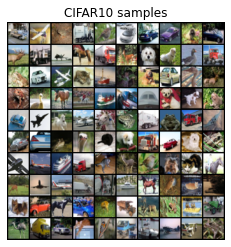

In [9]:
train_data, test_data = load_pickle('cifar10.pkl')
visualize_data(train_data, 'CIFAR10 samples')

In [10]:
class Generator(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
        
        # apply linear layer with output units 4 * 4 * 4 * dim, then relu
        self.preprocess = nn.Sequential(
            nn.Linear(in_features = 128, out_features = 4 * 4 * 4 * 128, bias=True ),
            nn.ReLU()
        )

        
        # apply transposed conv with stride 2, kernel size 2
        # then BN, then relu
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 4 * 128, out_channels = 2*128 ,kernel_size= 2 ,stride = 2, bias = True ),
            nn.BatchNorm2d(2*128),
            nn.ReLU()
        )
        # Then, [2*128,8,8]
        

        # apply transposed conv with stride 2, kernel size 2
        # then BN, then relu
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 2*dim, out_channels = dim, kernel_size=2,stride=2,bias=True ),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )


        self.deconv_out = nn.ConvTranspose2d(dim, 3,kernel_size=2, stride=2)
        # [batch, 3, 32, 32]

        self.tanh = nn.Tanh()

        self.noise = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))

    def forward(self, input):

        output = self.preprocess(input)
        output = output.view(-1, 4 * self.dim, 4, 4) 
        # [batch, 4*dim, 4, 4]

        output = self.block1(output)
        # [batch, 2*dim, 8,8]

        output = self.block2(output)
        # [batch, dim, 16,16]

        output = self.deconv_out(output)
        # [batch,3, 32,32]
        output = self.tanh(output)

        return output.view(-1, 3, 32, 32)


    def sample(self, n_samples):

        z = self.noise.sample([n_samples, 128]).cuda()
        # sample [batch, z_dim = 128] 

        return self.forward(z)

In [11]:
class Critic(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

        # sequence of Conv2D with stride 2 and LeakyRelU
        self.net = nn.Sequential(

            nn.Conv2d(in_channels = 3, out_channels = dim ,kernel_size = 2 ,stride = 2, padding=0, bias = True),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels= dim, out_channels= 2*dim, kernel_size=2 ,stride=2, bias = True),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels = 2*dim, out_channels = 4*dim, kernel_size = 2, stride = 2, bias = True),
            nn.LeakyReLU(),

            # [BATCH, 4*dim, 4 , 4 ]

        )
        self.linear = nn.Linear(4 * 4 * 4 * dim, 1)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1, 4 * 4 * 4 * self.dim)
        output = self.linear(output)
        return output

In [23]:
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.shape[0]

    # Calculate interpolation
    # x_t = t * x_real + (1 - t) x_fake

    # sample t
    t = torch.rand((batch_size,1,1,1)).cuda()

    # create x_t
    interpolated = torch.autograd.Variable(t*real_data + (1 - t)*fake_data)
    interpolated.requires_grad = True

    # apply critic to x_t
    d_output = critic(interpolated)
    gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                    grad_outputs=torch.ones(d_output.size()).cuda(),
                                    create_graph=True, retain_graph=True)[0]

    gradients = gradients.reshape(batch_size, -1)

    # compute gradient norm
    gradients_norm = torch.norm(gradients,dim = 1 )
    return ((gradients_norm - 1) ** 2)

In [24]:
def train(
    generator, 
    critic, 
    gen_optimizer,
    critic_optimizer,
    train_loader,
    critic_steps, 
    batch_size,
    n_epochs
):
    train_losses = []

    critic.train()
    generator.train()

    curr_iter = 0
    for epoch_i in range(n_epochs):
        batch_loss_history = []

        for batch_i, x in enumerate(tqdm(train_loader, desc=f'epoch {epoch_i}', leave=False)):
            curr_iter += 1
            x = x.clone().detach().cuda().float() #cuda()
            x = 2 * (x - 0.5)

            # do a critic update
            critic_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])
            gp = gradient_penalty(critic, x, fake_data)
            # D(x_fake) - D(x_real) + 10 * grad_pen
            d_loss = torch.mean(critic(fake_data) - critic(x) + 10*gp)
            d_loss.backward()
            critic_optimizer.step()
            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # -D(x_fake)
                g_loss = - torch.mean(critic(fake_data))
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history.append(g_loss.data.cpu().numpy())

        epoch_loss = np.mean(batch_loss_history)
        train_losses.append(epoch_loss)

    train_losses = np.array(train_losses)
    return train_losses


Total number of epochs: 80


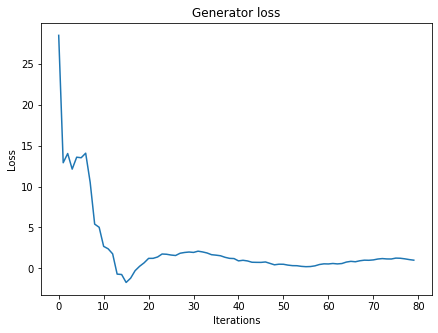

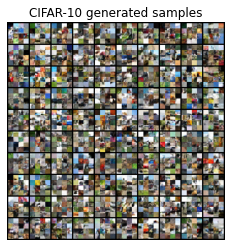

In [25]:
train_data, test_data = load_pickle('cifar10.pkl')
# train_data - np.array [5000,32,32,3] --- test - np.array [10000,32,32,3]
train_data = np.transpose(train_data, (0, 3, 1, 2)) / 255.0
# train_data.shape = [5000,3,32,32] and train_data's element is located between 0 and 1

BATCH_SIZE = 100
# numpy to pytorch
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

DIM = 128
N_ITERATIONS = 10000
CRITIC_STEPS = 4

N_EPOCHS = CRITIC_STEPS * N_ITERATIONS // len(train_loader)
print('Total number of epochs:', N_EPOCHS)

generator = Generator(dim=DIM).cuda()
critic = Critic(dim=DIM).cuda()

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0, 0.9))
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=2e-4, betas=(0, 0.9))

losses = train(
    generator, 
    critic, 
    gen_optimizer,
    critic_optimizer,
    train_loader,
    CRITIC_STEPS, 
    BATCH_SIZE, 
    N_EPOCHS
)

plot_gan_training(losses, 'Generator loss')


generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(1000)
    samples = samples.permute(0, 2, 3, 1).cpu().detach().numpy() * 0.5 + 0.5
    

show_samples(samples[:100] * 255.0, title='CIFAR-10 generated samples')